# Movies recommendation with Azure Open AI & Azure Cognitive Search
## Part 3 - Recommandations

<img src="https://github.com/retkowsky/images/blob/master/movies_search.png?raw=true">

In [1]:
# %pip install azure-search-documents --pre --upgrade

In [2]:
# %pip install youtube-search-python

In [3]:
import json
import movieposters as mp
import openai
import os
import pytz
import requests
import sys
import time

from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.models import Vector

from datetime import datetime
from dotenv import load_dotenv
from IPython.display import IFrame, display
from io import BytesIO
from PIL import Image
from youtubesearchpython import VideosSearch, Comments

In [4]:
sys.version

'3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]'

In [5]:
local_tz = pytz.timezone(requests.get("https://ipinfo.io").json()["timezone"])
print("Local time:", datetime.now(local_tz).strftime("%d-%b-%Y %H:%M:%S"))

Local time: 04-Sep-2023 13:08:02


In [6]:
print("Open AI version:", openai.__version__)

Open AI version: 0.27.9


In [7]:
load_dotenv("azure.env")

openai.api_type: str = "azure"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_base = os.getenv("OPENAI_API_BASE")
openai.api_version = os.getenv("OPENAI_API_VERSION")

acs_endpoint = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
acs_key = os.getenv("AZURE_SEARCH_ADMIN_KEY")

In [8]:
# Azure Open AI embeddings model to use
embeddings_engine = "text-embedding-ada-002"

- Vector search is in public preview
- Model name: text-embedding-ada-002
- Model version: 2
- API version: 2023-05-15

In [9]:
# Azure Cognitive Search index name to create
index_name = "moviereview"

## 1. Functions

In [10]:
def acs_delete_index(index_name):
    """
    Deleting an Azure Cognitive Search index
    Input: index name (string)
    """
    start = time.time()
    search_client = SearchIndexClient(
        endpoint=acs_endpoint, credential=AzureKeyCredential(acs_key)
    )

    try:
        print("Deleting the Azure Cognitive Search index:", index_name)
        search_client.delete_index(index_name)
        print("Done. Elapsed time:", round(time.time() - start, 2), "secs")
    except:
        print("Cannot delete index. Check the index name.")

In [11]:
def acs_index_stats(index_name):
    """
    Get statistics about Azure Cognitive Search index
    Input: index name (string)
    """
    url = (
        acs_endpoint
        + "/indexes/"
        + index_name
        + "/stats?api-version=2021-04-30-Preview"
    )
    headers = {
        "Content-Type": "application/json",
        "api-key": acs_key,
    }
    response = requests.get(url, headers=headers)
    print("Azure Cognitive Search index status for:", index_name, "\n")

    if response.status_code == 200:
        res = response.json()
        print(json.dumps(res, indent=2))
        document_count = res["documentCount"]
        storage_size = res["storageSize"]

    else:
        print("Request failed with status code:", response.status_code)

    return document_count, storage_size

In [12]:
def acs_index_status(index_name):
    """
    Azure Cognitive Search index status
    Input: index name (string)
    """
    print("Azure Cognitive Search Index:", index_name, "\n")

    headers = {"Content-Type": "application/json", "api-key": acs_key}
    params = {"api-version": "2021-04-30-Preview"}
    index_status = requests.get(
        acs_endpoint + "/indexes/" + index_name, headers=headers, params=params
    )

    try:
        print(json.dumps((index_status.json()), indent=5))
    except:
        print("Request failed with status code:", response.status_code)

In [13]:
def azure_openai_text_embeddings(text):
    """
    Generating embeddings from text using Azure Open AI
    Input: text
    Output: vector embedding
    """
    embeddings = openai.Embedding.create(
        input=text,
        deployment_id=embeddings_engine,
    )
    embeddings = embeddings["data"][0]["embedding"]

    return embeddings

In [14]:
def get_list(movielist):
    """
    Get list of movies
    Input: movies list (list)
    Output: results (text)
    """
    pattern = r"\d+\.\s(.+)"
    matches = re.findall(pattern, movielist)
    for idx, movie in enumerate(matches, start=1):
        print(f"Movie {idx}: {movie}.")

    return matches

## 2. Azure Cognitive Search index

### Azure Cognitive Search vector store
<img src="https://github.com/retkowsky/images/blob/master/vector_search_architecture.png?raw=true">

In [15]:
acs_index_status(index_name)

Azure Cognitive Search Index: moviereview 

{
     "@odata.context": "https://azurecogsearcheastussr.search.windows.net/$metadata#indexes/$entity",
     "@odata.etag": "\"0x8DBAA0BED295DB4\"",
     "name": "moviereview",
     "defaultScoringProfile": null,
     "fields": [
          {
               "name": "imdb_id",
               "type": "Edm.String",
               "searchable": false,
               "filterable": true,
               "retrievable": true,
               "sortable": true,
               "facetable": true,
               "key": true,
               "indexAnalyzer": null,
               "searchAnalyzer": null,
               "analyzer": null,
               "normalizer": null,
               "synonymMaps": []
          },
          {
               "name": "title",
               "type": "Edm.String",
               "searchable": true,
               "filterable": true,
               "retrievable": true,
               "sortable": false,
               "facetable": f

In [16]:
document_count, storage_size = acs_index_stats(index_name)

Azure Cognitive Search index status for: moviereview 

{
  "@odata.context": "https://azurecogsearcheastussr.search.windows.net/$metadata#Microsoft.Azure.Search.V2021_04_30_Preview.IndexStatistics",
  "documentCount": 10784,
  "storageSize": 564466206
}


In [17]:
print("Number of documents in the index =", f"{document_count:,}")
print("Size of the index =", round(storage_size / (1024 * 1024), 2), "MB")

Number of documents in the index = 10,784
Size of the index = 538.32 MB


## 3. Functions

In [18]:
def azure_chatgpt_movies(prompt, max_retries=3, retry_delay=1):
    """
    Chat GPT with Azure Open AI
    Input: prompt (text)
    Output: results (string)
    """
    for _ in range(max_retries):
        try:
            response = openai.ChatCompletion.create(
                engine="gpt-35-turbo",  # Should be deployed in the AOAI studio
                messages=[
                    {
                        "role": "system",
                        "content": "You are an AI assistant that helps people to find \
                        information about movies.",
                    },
                    {"role": "user", "content": prompt},
                ],
                temperature=0.9,
                max_tokens=800,
                top_p=1,
                frequency_penalty=0,
                presence_penalty=0,
                stop=None,
            )

            resp = response["choices"][0]["message"]["content"]

            print("\033[1;31;34mPrompt:", prompt)
            print("\n\033[1;31;32mResponse:", resp)
            print("\033[1;31;35m")
            print("Powered by Azure AI")
            # Local time
            local_tz = pytz.timezone(
                requests.get("https://ipinfo.io").json()["timezone"]
            )
            print(datetime.now(local_tz).strftime("%d-%b-%Y %H:%M:%S"))

            return resp

        except Exception as e:
            print("Error:", str(e))
            print("Retrying...")
            time.sleep(retry_delay)

    print("Maximum retries exceeded. Unable to get a response.")

    return None

In [19]:
def get_movie_poster(imdb_id):
    """
    Display movie poster from its IMDB id
    Input: imdb id (string)
    Output: display image file and save as an image file
    """
    poster = mp.get_poster(id=imdb_id)
    response = requests.get(poster)

    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        display(img)
        # Save as a local file
        os.makedirs("movieposter", exist_ok=True)
        posterfile = os.path.join("movieposter", "movie_" + str(imdb_id) + ".jpg")
        img.save(posterfile)
    else:
        print("Failed to fetch the movie image.")

In [20]:
def get_trailer(movietitle):
    """
    Get youtube video trailer
    Input: movie title (string)
    Output: Display the trailer video
    """
    # Search video on youtube
    videosSearch = VideosSearch(movietitle, limit=1)
    video_results = videosSearch.result().get("result")

    if video_results:
        print("\033[1;31;34m")
        video_id = video_results[0].get("id")
        video_url = f"https://www.youtube.com/watch?v={video_id}"
        print("\033[1;31;34m", video_url)
        vid = IFrame(
            src=f"https://www.youtube.com/embed/{video_id}", width="560", height="315"
        )
        display(vid)

        # Get the first 20 Youtube video comments
        print("YouTube video comments for", movietitle, ":")
        comments = Comments.get(video_id)
        print("\033[1;31;32m")

        for idx, comment in enumerate(comments.get("result")):
            print(f"Comment {idx+1:02}: {comment.get('content')}")
        print("\033[0m")
    else:
        print("No video found on YouTube.")

In [21]:
def get_all_movies_trailers(movies_list):
    """
    Get movie trailers from a list of movies
    Input: movies list (string)
    Output: Display the trailer video for each element of the list
    """
    for movie in movies_list:
        print(movie)
        try:
            get_trailer(movie)
        except:
            print("Error")
        print()

In [22]:
def acs_movies_with_posters(title):
    """
    Cross Field Search
    Input: title (string)
    Ouput: results (string)
    """
    search_client = SearchClient(
        acs_endpoint, index_name, credential=AzureKeyCredential(acs_key)
    )

    vector = Vector(value=azure_openai_text_embeddings(title), k=1, fields="embed_title")

    results = search_client.search(
        search_text=None,
        vectors=[vector],
        select=[
            "imdb_id",
            "title",
            "cast",
            "director",
            "description",
            "genres",
            "year",
        ],
        top=1,
    )

    for result in results:
        if result["@search.score"] >= 0.9:
            print("\033[1;31;34m")
            print(f"Movie title: {result['title']}")
            print(f"Movie ID: {result['imdb_id']}")
            # Get movie poster
            get_movie_poster(result["imdb_id"])
            print("\033[1;31;32m")
            print(f"Description: {result['description']}")
            print("\033[0m")
            print(f"Cast: {result['cast']}")
            print(f"Director: {result['director']}")
            print(f"Genres: {result['genres']}")
            print(f"Year: {result['year']}")
            print("\033[1;31;35m")
            print(f"Score = {result['@search.score']}")
        
        else:
            print("\033[1;31;91m")
            print(
                "Note: The movie",
                title,
                "is not available in the Azure Cognitive search index",
            )
            print("\033[0m")

In [23]:
def acs_movies_results(movies_list):
    """
    Find movies using Azure Cognitive Search from a list of movies
    Input: movies list (list)
    Output: results
    """
    for movie in movies_list:
        acs_movies_with_posters(movie)

# 4. Recommandation system

In [24]:
genres_list = [
    "Action",
    "Adventure",
    "Fantasy",
    "Science Fiction",
    "Crime",
    "Thriller",
    "Animation",
    "Family",
    "Western",
    "Romance",
    "Horror",
    "Mystery",
    "History",
    "War",
    "Drama",
    "Comedy",
    "Music",
]

len(genres_list)

17

In [25]:
actors_list = [
    "Robert De Niro",
    "Al Pacino",
    "Jack Nicholson",
    "Dustin Hoffman",
    "Clint Eastwood",
    "Harrison Ford",
    "Tom Hanks",
    "Denzel Washington",
    "Morgan Freeman",
    "Mel Gibson",
    "Arnold Schwarzenegger",
    "Bruce Willis",
    "Robin Williams",
    "Kevin Costner",
    "Sean Connery",
    "Johnny Depp",
    "Samuel L. Jackson",
    "Jeff Goldblum",
    "Eddie Murphy",
    "Kurt Russell",
    "Michael Douglas",
    "Bill Murray",
    "John Travolta",
    "Richard Gere",
    "Nicolas Cage",
    "Tom Cruise",
    "Keanu Reeves",
    "Kevin Bacon",
    "Gene Hackman",
    "Danny DeVito",
    "Val Kilmer",
    "John Cusack",
    "Tim Robbins",
    "Steve Martin",
    "Patrick Swayze",
    "Tom Selleck",
    "Wesley Snipes",
    "Edward Norton",
    "Alec Baldwin",
    "Jim Carrey",
    "Will Smith",
    "Brad Pitt",
    "George Clooney",
    "Sean Penn",
    "Robert Redford",
    "Richard Dreyfuss",
    "Mark Wahlberg",
    "Johnny Depp",
    "Billy Crystal",
    "Harvey Keitel",
]

len(actors_list)

50

In [26]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

## 1. Based on some preferences
### Test 1

In [27]:
mytopgenres = ", ".join([genres_list[0], genres_list[3], genres_list[4]])
mytopgenres

'Action, Science Fiction, Crime'

In [28]:
mytopactors = ", ".join(
    [actors_list[2], actors_list[3], actors_list[4], actors_list[10], actors_list[20]]
)
mytopactors

'Jack Nicholson, Dustin Hoffman, Clint Eastwood, Arnold Schwarzenegger, Michael Douglas'

In [33]:
prompt = f"I want to see a movie. Can you recommend me 10 movies? \
My favorite genres are: {mytopgenres} and my favorite actors are: {mytopactors}.\
 I want you to save only the movie title in a numbered list with the release year."

answer = azure_chatgpt_movies(prompt)

Prompt: I want to see a movie. Can you recommend me 10 movies? My favorite genres are: Action, Science Fiction, Crime and my favorite actors are: Jack Nicholson, Dustin Hoffman, Clint Eastwood, Arnold Schwarzenegger, Michael Douglas. I want you to save only the movie title in a numbered list with the release year.

Response: Sure! Based on your preferred genres and actors, here are 10 movie recommendations:

1. The Terminator (1984)
2. Blade Runner (1982)
3. The Godfather (1972)
4. Die Hard (1988)
5. Lethal Weapon (1987)
6. The Dark Knight (2008)
7. Heat (1995)
8. Speed (1994)
9. The Fugitive (1993)
10. The Departed (2006)

I hope you find this list helpful!

Powered by Azure AI
04-Sep-2023 13:10:56


In [34]:
movies_list = get_list(answer)

Movie 1: The Terminator (1984).
Movie 2: Blade Runner (1982).
Movie 3: The Godfather (1972).
Movie 4: Die Hard (1988).
Movie 5: Lethal Weapon (1987).
Movie 6: The Dark Knight (2008).
Movie 7: Heat (1995).
Movie 8: Speed (1994).
Movie 9: The Fugitive (1993).
Movie 10: The Departed (2006).



Movie title: The Terminator
Movie ID: tt0088247


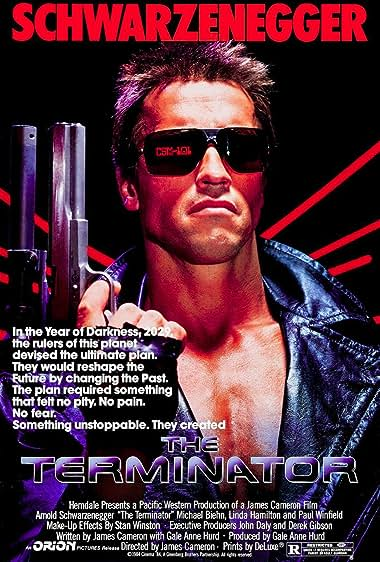


Description: In the post-apocalyptic future reigning tyrannical supercomputers teleport a cyborg assassin known as the "Terminator" back to 1984 to kill Sarah Connor whose unborn son is destined to lead insurgents against 21st century mechanical hegemony. Meanwhile the human-resistance movement dispatches a lone warrior to safeguard Sarah. Can he stop the virtually indestructible killing machine?

Cast: Arnold Schwarzenegger Michael Biehn Linda Hamilton Paul Winfield Lance Henriksen
Director: James Cameron
Genres: Action Thriller Science Fiction
Year: 1984

Score = 0.95015645


In [35]:
acs_movies_with_posters(movies_list)

In [36]:
get_all_movies_trailers(movies_list)

The Terminator (1984)

 https://www.youtube.com/watch?v=k64P4l2Wmeg


YouTube video comments for The Terminator (1984) :

Comment 01: I remember seeing this in the theater with my friends, and we all thought it looked pretty cheesy. But we went to the movie anyway, figuring it might be at least dumb fun. Then the movie totally blew us away! We knew right away that this movie was going to go down in history.
Comment 02: One of the few movies that actually deserves its 100% on rotten tomatoes. This movie is a masterpiece. A true 80s scifi/horror... I couldn't imagine how exciting it would have been to see in 1984 opening night!
Comment 03: This film is a masterpiece.
Comment 04: I can tell you I was there in the cinema when it was released and it blew me away. I declared it there and then the single greatest action film and sf of all time. It literally was a perfect film. Everything that I wanted to happen, happened. Flawless in every way and a masterpiece. I couldn't get over the movie. I've never seen so many people transfixed at the cinema. Jaws did the

YouTube video comments for Blade Runner (1982) :

Comment 01: This is an amazing masterpiece of a movie. It’s stunning and the mix of the soundtrack with the cinematography and amazing casting works perfectly. Anyone who sees this should NOT be fooled by the trailer. This is an incredibly sophisticated movie, and it’s a stunning movie. I love this so much
Comment 02: Masterpiece of Ridley Scott's genious. Without doubt Blade Runner is the movie which ages best among all the sci-fi movies. 10 years, 20 years, 30 years ... you can watch it as a timeless classic any time. That is true magic.
Comment 03: I must admit I was not a fan of this movie when it first came out, but over the years it has grown on me. 
Comment 04: 2020 expectations: How flying cars work
Comment 05: Back in 1982, when this movie came out, 2019 must have seemed so far into the future. Now, as I type this, 2019 is a part of history.
Comment 06: This film.... let me tell you about this film.
Comment 07: BLADE RUNNER was

YouTube video comments for The Godfather (1972) :

Comment 01: In an age where the word "masterpiece" is casually thrown left and right, 
Comment 02: I was lucky enough to see this masterpiece in theaters last night, and it was absolutely terrific. Even though I’ve seen it a thousand times before, seeing it on the big screen was incredible.
Comment 03: No cringe fighting, suspense plan attack, no standard action, one of the perfect film ever made in the world.
Comment 04: My dad watched it in 1972 in theatres and I was lucky enough to take him to the theatres 50 years later and watch this once in a lifetime masterpiece. He enjoyed it even better than what he did then 
Comment 05: This was one of the most incredible theater experiences I've ever had in my life, thank you Paramount and Francis Ford Coppola for this amazing treat!
Comment 06: I can never get enough of this Movie. it's one of the best written and directed movies I have ever seen.
Comment 07: Still one of the best films eve

YouTube video comments for Die Hard (1988) :

Comment 01: As they say, "Yippee ki yay" Such an iconic film! Every aspect of it was amazing, the storyline, the characters, the soundtrack, and the action were all great and literally legendary! Decided to watch it on Christmas day again, and what a film. Hard to find anything similar these days, what a time. Such an amazing cast as well, especially with Willis in his prime. So sad to see him in the condition he is now, and hearing about the passing of  Gilyard, few months back. But we can all agree on this movie and their talent will always have an everlasting legacy.  If you're looking for a perfect action-packed, film; This is it! Unforgettable.
Comment 02: Die Hard is a Christmas movie and nobody's gonna convince me differently.
Comment 03: I’m here cause just like you I heard Bruce retired today cause of a disease affecting his speech ability. Thank you Bruce for all the classics including this masterpiece!!!
Comment 04: Best Christma

YouTube video comments for Lethal Weapon (1987) :

Comment 01: Rest in peace to  Richard Donner  (1930-2021). The one who made movies that cant get old.
Comment 02: 80’s and 90’s action movie trailers are truly a lost art. Absolutely badass! Remember sitting in the cinema watching these back in the day and being so pumped to see these gems.
Comment 03: The trailer man's voiceover is legendary on these 80s films, especially on home video rental tapes.Simple and effective. Much missed now as I'm sure he passed away long ago.
Comment 04: The 80s were freaking awesome.  I feel sorry for folks that didn’t experience it
Comment 05: Mel Gibson got snubbed for an Oscar Nomination for this incredible performance. That suicide scene is masterfully acted by him and that scene alone deserves him the Oscar Nom. Overall this is one of the best Action / Comedy and Thriller films of all time!
Comment 06: Comecei a ver os três primeiros episódios e simplesmente estou a adorar!! Já viciei!!
Comment 07: 

YouTube video comments for The Dark Knight (2008) :

Comment 01: 10 years later, still one of the greatest movies ever made.
Comment 02: Still the greatest superhero movie ever made hands down. Goosebumps even after 14 years.
Comment 03: As a true Marvel fan, this is a masterpiece.
Comment 04: It’s difficult to describe the experience of having seen this opening day in a crowded theater. On screen, this movie was alive. It was like it was actually happening. To this day, the greatest theatrical experience I’ve ever had.
Comment 05: Just finished watching the trilogy for the first time. Saw some scenes as a child, but now I finally realise why it has 9.0 on IMDb. From the cast, scenes, music, story and the message it sends I can't say anything else than that it's a MASTERPIECE.
Comment 06: I’ve never left a movie more excited and happy in my life. This movie was an absolute masterpiece
Comment 07: I am truly jealous of those who saw this in theaters.
Comment 08: It’s hard to adequately 

YouTube video comments for Heat (1995) :

Comment 01: Guys if u need a movie request please let me know I will do my best to download them
Comment 02: How you managed to get this entire 3 hour masterpiece on YouTube in pretty good quality and still have it not taken down yet is absolutely incredible
Comment 03: This is by far one of the most tightly executed films. No holes in the storyline, each scene intricately connects to the next, slowly connecting the story. One needs to LISTEN to every line & will understand the web of this superbly written story. This film runs on all cylinders for those who pay attention to all the great details. Michael Mann would never write a loose fitting story, not his style. He’s always tight, pulling it all together. Take the time, concentrate on the dialogue & this film will always deliver.
Comment 04: One of the greatest movies of the last thirty years. Astonishingly deep storyline, excellent script, top tier acting. What a treasure.
Comment 05: Truly

YouTube video comments for Speed (1994) :

Comment 01: One of the best action movies of the 90s, still holds up.
Comment 02: 90s era of Action blockbusters will never ever be replicated. The best decade!!! 
Comment 03: One of the best action movies of the 90’s. You could just FEEL the heat coming off of this movie. I truly miss this era of film making. When action film directors really had to work hard to sell you their story. Glad to have this film as apart of my young adult years.
Comment 04: Speed, Die Hard with a Vengeance, Bad Boys, Eraser, The Negotiator, Metro,  True Lies, Terminator 2, Crimson Tide, The Rock etc. the greatest action movies of the 1990's hands down! That was a glorious decade, man.
Comment 05: This is still one of my favorite movies, just never gets old. You can really watch this masterpiece over and over again. The tension, the emotions and effects are brilliant. Also each role is played so well. Just a banger of a  movie, even to this day.
Comment 06: One of t

YouTube video comments for The Fugitive (1993) :

Comment 01: The sign of a good movie is if you watch it over and over again through the years without getting tired of it.  The Fugitive never gets old.  The plot moves along at a quick and exciting clip. This is Harrison Ford's best part.
Comment 02: One of the best movies of the 90's and it's now 25 years old.
Comment 03: Who’s here after seeing the story with Shane and Ryan?
Comment 04: I love this movie! My favorite part was where he risked getting caught at the hospital to save a boy's life.
Comment 05: Honestly one of the best action thrillers ever! My family loves this movie, we always watch if it’s playing on TV and we’ve seen it like 30 times already
Comment 06: That's how a trailer should be. Mainly scenes from the first half giving us the main plot line without going into detail about the characters
Comment 07: No idea how Harrison Ford wasn’t awarded an Oscar for this. Incredible movie. One of my all time favorites now. Wow.

YouTube video comments for The Departed (2006) :

Comment 01: This movie deserves more love than it got. One of the best movies and probably the best casts teams of all time
Comment 02: 15 years later and this movie is still freaking awesome. Great cast.
Comment 03: 10 years later and this movie is still awesome
Comment 04: this is perhaps the best cast a movie ever got.
Comment 05: Just watched this last week, bloody amazing film 
Comment 06: I love how versatile Mark Damon is as an actor, being able to play two characters in one film so seamlessly....perfection. 
Comment 07: One of the best casts ever, everyone gave a great performance + the dialogue is memorable and its well paced. and overall one of the best movies of this century
Comment 08: Never seen a movie so well cast before.
Comment 09: one of my favorite movies of all time
Comment 10: What a film, what a sound track, what a cast, what a plot,  what a film absolutely worth watching 10 times at least, brilliant.
Comment 11: 2

## Test 2

In [37]:
mytopgenres = ", ".join([genres_list[8]])
print(mytopgenres)

mytopactors = ", ".join(
    [actors_list[30], actors_list[40], actors_list[45], actors_list[47]]
)
print(mytopactors)

Western
Val Kilmer, Will Smith, Richard Dreyfuss, Johnny Depp


In [38]:
prompt = f"I want to see a movie. Show me a list of 3 movies. \
My favorite genres are: {mytopgenres} and my favorite actors are: {mytopactors}.\
 I want you to save only the movie title in a numbered list with the release year."

answer = azure_chatgpt_movies(prompt)

Prompt: I want to see a movie. Show me a list of 3 movies. My favorite genres are: Western and my favorite actors are: Val Kilmer, Will Smith, Richard Dreyfuss, Johnny Depp. I want you to save only the movie title in a numbered list with the release year.

Response: Sure, here are 3 movies that match your preferences: 

1. Tombstone (1993)
2. Wild Wild West (1999)
3. The Lone Ranger (2013)

Powered by Azure AI
04-Sep-2023 13:12:01


In [39]:
movies_list = get_list(answer)

Movie 1: Tombstone (1993).
Movie 2: Wild Wild West (1999).
Movie 3: The Lone Ranger (2013).



Movie title: Tombstone
Movie ID: tt0108358


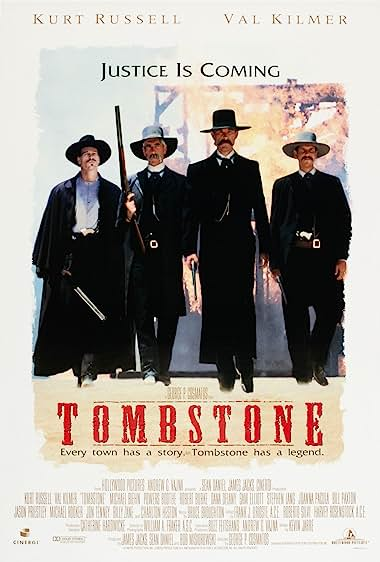


Description: Legendary marshal Wyatt Earp now a weary gunfighter joins his brothers Morgan and Virgil to pursue their collective fortune in the thriving mining town of Tombstone. But Earp is forced to don a badge again and get help from his notorious pal Doc Holliday when a gang of renegade brigands and rustlers begins terrorizing the town.

Cast: Kurt Russell Val Kilmer Sam Elliott Bill Paxton Stephen Lang
Director: George P. Cosmatos
Genres: Action Adventure Drama History Western
Year: 1993

Score = 0.94058454


In [40]:
acs_movies_with_posters(movies_list)

In [41]:
get_all_movies_trailers(movies_list)

Tombstone (1993)

 https://www.youtube.com/watch?v=MICPyrnGYwg


YouTube video comments for Tombstone (1993) :

Comment 01: A room of people that thinks he's just joking around but Johnny and Doc knew. Doc mimicked his entire routine by only seeing it once, a routine Johnny probably practiced many times to get down. What a scene, what a movie
Comment 02: “Not Me, I’m in my prime” greatest movie line ever. Val killed it 
Comment 03: Watching Val play that role never gets old. He really sold his sickness and his final seen actually brought a tear to my eye.
Comment 04: “Look darlin, it’s Johnny Ringoo” kills me everytime
Comment 05: I know everyone creams over Val Kilmer, and rightly so, but the 
Comment 06: Val Kilmer is grossly underrated, The guy could do it all. Comedy, action and drama. He should have had a lot more under his belt.
Comment 07: Oscar winners get forgotten, but Legends never die. Val Kilmer gives one of the greatest performances ever in the film.
Comment 08: No one has ever portrayed an old western character with so much personalit

YouTube video comments for Wild Wild West (1999) :

Comment 01: I don’t care what people say, this film absolutely slaps! More so now.
Comment 02: Saw this movie when I was a kid and it still looks badass. The Series is pretty good as well.
Comment 03: Say what you want about the story, but the movie still looks great after almost 20 years.
Comment 04: I absolutely love this movie and If you think the Movie and this video/song if on fire should check out the VMA live performance they killed it!
Comment 05: I loved this movie as a kid...and still do as an adult :P
Comment 06: this movie is fucking amazing.  i do not understand all the hate.  it's pure popcorn steampunk gold.
Comment 07: Is it weird to admit that despite being more hated Star Wars Episode 1: The Phantom Menace (1999), I actually love this movie?
Comment 08: When you choose this over being the lead actor in the matrix 
Comment 09: I miss the 90's lol. Movies were so much more goofy and laid back. lol
Comment 10: We need a

YouTube video comments for The Lone Ranger (2013) :

Comment 01: You can put Johnny Depp in any movie in the world and he can make it 10 times better and funnier
Comment 02: I don’t care what critics and most people say, I love this movie 10 / 10
Comment 03: “Makes no difference. We are already ghosts”
Comment 04: My dad and grandfather both watched westerns and classic horror movies with me growing up. This one, the 2013 version is one in a collection of many great movies I have saved to show my kids and grandkids one day..I do not understand how this movie was poorly received. It was amazing.
Comment 05: I really want to see this movie. Every clip with Johnny Depp seems funny as hell.
Comment 06: I always loved Johnny Depp's comedic performance
Comment 07: I love the movie shattering the Western heroics (the old shows about Lone Ranger), with adding Western realistic brutality and comedy. (The clashes between US army and Native Americans back then are pretty much messed up)
Comment 0

## 2. Based on some history
### Test 1

In [42]:
myfavoritemovies = "Jaws, 47 Meters Down, The Shallows"

In [43]:
prompt = f"My favorites movies are: {myfavoritemovies}.\
 Can you suggest me some 3 similar movies made before 2015? \
 I want you to save only the movie title in a numbered list with the release year."

answer = azure_chatgpt_movies(prompt)

Prompt: My favorites movies are: Jaws, 47 Meters Down, The Shallows. Can you suggest me some 3 similar movies made before 2015?  I want you to save only the movie title in a numbered list with the release year.

Response: Sure, here are three similar movies that were made before 2015:

1. Open Water (2003)
2. Deep Blue Sea (1999)
3. The Reef (2010)

Powered by Azure AI
04-Sep-2023 13:12:09


In [44]:
movies_list = get_list(answer)

Movie 1: Open Water (2003).
Movie 2: Deep Blue Sea (1999).
Movie 3: The Reef (2010).



Movie title: Open Water
Movie ID: tt0374102


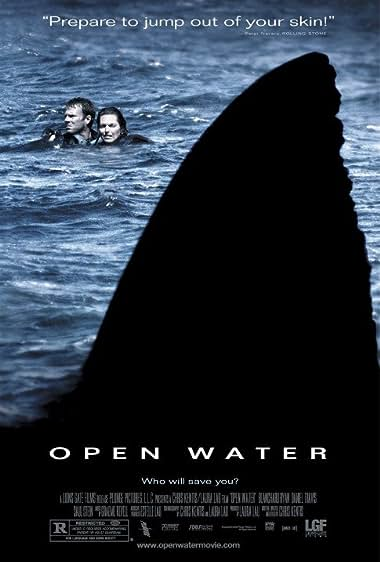


Description: Two divers are left out at sea without a boat. Thereâ€™s nothing but water for miles unless they look at whatâ€™s underneath them...

Cast: Blanchard Ryan Daniel Travis Saul Stein Michael E. Williamson Christina Zenato
Director: Chris Kentis
Genres: Drama Thriller
Year: 2004

Score = 0.96054286


In [45]:
acs_movies_with_posters(movies_list)

In [46]:
get_all_movies_trailers(movies_list)

Open Water (2003)

 https://www.youtube.com/watch?v=Z9q1qJi1nMs


YouTube video comments for Open Water (2003) :

Comment 01: The fact that the employees who left them behind did not go to jail for their deaths is shocking.
Comment 02: I'll never forget the way this ending made me feel. As I walked out the door to the parking lot, the bright sun felt so weird after 90 minutes of literal and figurative darkness. I felt dead inside. Just totally empty.
Comment 03: this movie had a budget of $100,000 and made $55 million in box office. incredible
Comment 04: Finally saw this movie, it was phenomenal. One of the scariest movies ever.
Comment 05: To think their families never got to know the truth about what happened to them is utterly heartbreaking.
Comment 06: Watched it today, the ending was so intense and real. I thought they'd be rescued in the end but it's so sad to see them die and it's actually chilling to know that this was based on a true story.
Comment 07: As a diver this has to be the ultimate nightmare.....especially when it turns dark. .
Com

YouTube video comments for Deep Blue Sea (1999) :

Comment 01: I LOVE this movie, I don't care what anyone says. I remember seeing this in theaters in 1999. Great memories. This classic turns 24 today.
Comment 02: So glad this movie is getting some much deserved love.
Comment 03: This was one the best movies from the ninties and hard to believe it was released in movie theaters 20 years at the end of    July doesn't seem like that long ago.
Comment 04: Was the first R rated movie I got to see in the theater. And loved every moment of it. Still the best shark movie after Jaws.
Comment 05: One of the best movies of my childhood 
Comment 06: Best shark movie ever. Sam Jackson getting abruptly eaten by a shark is still one of the best kills in any movie ever.
Comment 07: My favourite shark film - even though it’s my first when I was like 12 - so nostalgic 
Comment 08: This is the best film about sharks, it was my first film about sharks, and it was after this film that I fell in love
Comme

YouTube video comments for The Reef (2010) :

Comment 01: This is arguably one of the most realistic shark movies ever made. The films goal was to deliver an authentic lost at sea, shark attack experience and I think it did just that. If you've imposed the Hollywood movie formula onto this movie you've misunderstood what it is and set out to be. It's a glimpse into what a grim situation like that might actually be like. A very realistic and terrifying glimpse IMO.
Comment 02: i absolutely loved this film. with my enormous fear of sharks , its the worst scenario i could ever imagine being in. 
Comment 03: This was a surprisingly good movie.  I thought the acting was believable and I particularly loved how they drew out the suspense.  Silly shark roars aside, it's definitely worth viewing, maybe even more than once!
Comment 04: Ive been in a situation like this, and I can tell you people this is as real as a film can get to real life, I was fishing with 2 friends near the Solomon islands

### Test 2

In [47]:
myfavoritemovies = "Manhattan, French connection, Serpico"

In [48]:
prompt = f"My favorites movies are: {myfavoritemovies}.\
 Can you suggest me some 5 similar movies? \
 I want you to save only the movie title in a numbered list with the release year."

answer = azure_chatgpt_movies(prompt)

Prompt: My favorites movies are: Manhattan, French connection, Serpico. Can you suggest me some 5 similar movies?  I want you to save only the movie title in a numbered list with the release year.

Response: Yes, I can definitely help you with that. Here are 5 similar movies to your favorites:

1. "Taxi Driver" (1976)
2. "Annie Hall" (1977)
3. "Chinatown" (1974)
4. "The Conversation" (1974)
5. "Dog Day Afternoon" (1975)

Powered by Azure AI
04-Sep-2023 13:12:18


In [49]:
movies_list = get_list(answer)

Movie 1: "Taxi Driver" (1976).
Movie 2: "Annie Hall" (1977).
Movie 3: "Chinatown" (1974).
Movie 4: "The Conversation" (1974).
Movie 5: "Dog Day Afternoon" (1975).



Movie title: Taxi Driver
Movie ID: tt0075314


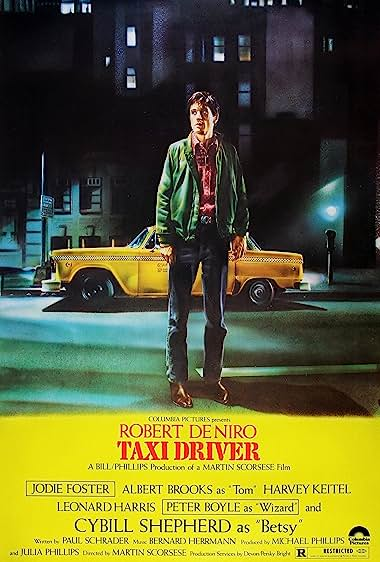


Description: A mentally unstable Vietnam War veteran works as a night-time taxi driver in New York City where the perceived decadence and sleaze feeds his urge for violent action attempting to save a preadolescent prostitute in the process.

Cast: Robert De Niro Cybill Shepherd Harvey Keitel Jodie Foster Peter Boyle
Director: Martin Scorsese
Genres: Crime Drama
Year: 1976

Score = 0.9408494


In [50]:
acs_movies_with_posters(movies_list)

In [51]:
get_all_movies_trailers(movies_list)

"Taxi Driver" (1976)

 https://www.youtube.com/watch?v=T5IligQP7Fo


YouTube video comments for "Taxi Driver" (1976) :

Comment 01: This is going to be a great movie, can't wait for 1976
Comment 02: A film that will still be relevant for decades to come.
Comment 03: An absolute masterpiece. Watching De Niro’s portrayal of Bickel’s descent into madness fuelled by a hatred of a society from which he feels disconnected, should serve as a warning to those in positions of power today that actively seek to isolate, denigrate and segregate certain classes of people by their increasingly insane ideology of holding the generation of today responsible for the sins of their ancestors.
Comment 04: can’t wait for this to come out
Comment 05: One of the greatest movies ever made. De Niro and Martin are the greatest combination in the history of film.
Comment 06: When i watched this movie for the first time, I thought it was a normal movie. Now, i realise what a masterpiece I've watched. That new York of 70s is also a character in the movie along with an accurate depi

YouTube video comments for "Annie Hall" (1977) :

Comment 01: I don't understand how people could say it was boring, the trailer even has a certain charm and humor about it that just makes it magnetic
Comment 02: Woody Allen and Martin Scorcese are incredible they're both very talented on portraying us, we, humans, people and life as it goes. All the feeling, sadness, loss, happiness, dreams, struggle, pain,... they really feel it all and know how to share all this to the audience
Comment 03: In most of his masterpieces, Woody Allen takes for himself the most annoying, non-stop-talking, neurotic characters, and let's the other actors to shine with the most compelling, warm and interesting ones.
Comment 04: Its one of my absolute fav even though i admit i don't get quite a few jokes. This movie has such an amazing influence even to this day cinema.
Comment 05: Greatest romantic comedy of all time.
Comment 06: I feel like Woody Allen's the only guy who's been able to do 'rich white New Y

YouTube video comments for "Chinatown" (1974) :

Comment 01: A MASTERPIECE of a film. From the costumes, the hair and makeup. Everything about this film was done to perfection. The actors are at their prime  and Roman Polanski's directing is masterful. One of Hollywood's best films. Personally, I think it's the BEST film of L.A. in the 30's.
Comment 02: In 1974 I was ten years old. I first saw Chinatown on TV in 1978. A brilliant story about water in an unstable environment. A timeless movie that never goes out of date!!
Comment 03: It's weird to think that making this movie set in 1937 then would be the equivalent of making a movie set in 1984 this year.
Comment 04: Each single shot is to enjoy endless without being bored.Just incredible. Polanski is the utmost   badass in cinema history.
Comment 05: One of the best films of the seventies which is saying something.  Three excellent performances, Nicholson, Dunaway and Huston.
Comment 06: The 70s were not a great time for Americans but

YouTube video comments for "The Conversation" (1974) :

Comment 01: I saw this again yesterday, first time in MANY years. The equipment may be outdated, but the theme still resonates today. A very good film. I also love the line from it, "I'm not afraid of death. I am afraid of murder." Ditto Gene, very much, ditto.
Comment 02: I finally got around to watching The Conversation last week after ignoring it for 40 years. Shame on me for not watching it sooner, an amazing movie even though all the surveillance equipment is very outdated by today's standards (but top-of-the-line in 1974), great movie, and the ending was a big surprise. Gene Hackman never fails to deliver (and he learned to play the saxophone for his role).
Comment 03: I think this is Coppola's best film, and deep down, I think he does also.  Clearly inspired by Blow Up it shows a technician being trapped by forces he does not comprehend until it is too late.  Hackman  should have won an Oscar for his acting.  And this is al

YouTube video comments for "Dog Day Afternoon" (1975) :

Comment 01: What a power of improvisation, a small circle of such quality actors as AL Pacino. He won only one Oscar, but that Oscar is a ridiculous benchmark for such performances, such performances are beyond the limits of art. Long live my hero of youth, one of the best actors of all time, who changed the film world forever, and whose roles set the standards of modern acting!
Comment 02: How does al Pacino manage to look like a whole different person in each movie
Comment 03: I so loved Pacino teasing and shouting outside the bank at everyone and the crowd loved it.
Comment 04: A dynamite movie, not a dull moment and the plot twists. In my Top 50 of favorite films
Comment 05: Al Pacino has eyes, beautiful eyes, most beautiful eyes a mortal can have
Comment 06: I was trying to find something to watch on TV when I was 12 and for some reason I stopped at the channel playing this. Al Pacino's acting hooked me in and I had no idea 

## 3. Post Processing

In [52]:
acs_index_status(index_name)

Azure Cognitive Search Index: moviereview 

{
     "@odata.context": "https://azurecogsearcheastussr.search.windows.net/$metadata#indexes/$entity",
     "@odata.etag": "\"0x8DBAA0BED295DB4\"",
     "name": "moviereview",
     "defaultScoringProfile": null,
     "fields": [
          {
               "name": "imdb_id",
               "type": "Edm.String",
               "searchable": false,
               "filterable": true,
               "retrievable": true,
               "sortable": true,
               "facetable": true,
               "key": true,
               "indexAnalyzer": null,
               "searchAnalyzer": null,
               "analyzer": null,
               "normalizer": null,
               "synonymMaps": []
          },
          {
               "name": "title",
               "type": "Edm.String",
               "searchable": true,
               "filterable": true,
               "retrievable": true,
               "sortable": false,
               "facetable": f

In [53]:
document_count, storage_size = acs_index_stats(index_name)

Azure Cognitive Search index status for: moviereview 

{
  "@odata.context": "https://azurecogsearcheastussr.search.windows.net/$metadata#Microsoft.Azure.Search.V2021_04_30_Preview.IndexStatistics",
  "documentCount": 10784,
  "storageSize": 564466206
}


### We can delete the index if needed

In [ ]:
# acs_delete_index(index_name)

> End